In [1]:
import numpy as np
import os 
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale = 1.4)
from sklearn.utils import shuffle 
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf 
from tqdm import tqdm 

In [2]:
class_names = ['hammer', 'screwdriver', 'wrench']

class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150,150)

In [3]:
def load_data():

    datasets = ['E:/Mini proj/tools_dataset/train_data_V2/train_data_V2',
                'E:/Mini proj/tools_dataset/validation_data_V2/validation_data_V2']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

                

In [4]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading E:/Mini proj/tools_dataset/train_data_V2/train_data_V2


100%|██████████| 800/800 [00:00<00:00, 1003.07it/s]


Loading E:/Mini proj/tools_dataset/validation_data_V2/validation_data_V2


100%|██████████| 400/400 [00:00<00:00, 585.74it/s]


In [5]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 2400
Number of testing examples: 1200
Each image is of size: (150, 150)


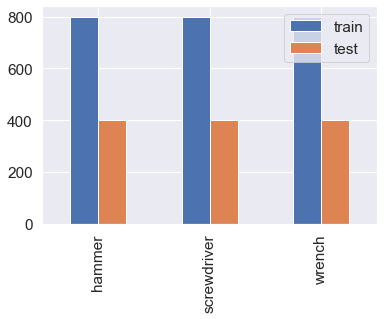

In [6]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

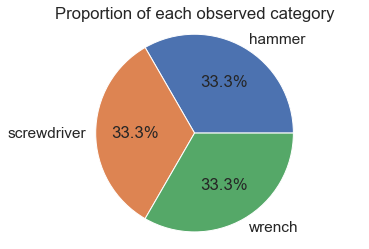

In [7]:
plt.pie(train_counts,
        explode=(0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

In [8]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

In [9]:
def display_random_image(class_names, images, labels):
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{}:'.format(index) + class_names[labels[index]])
    plt.show()

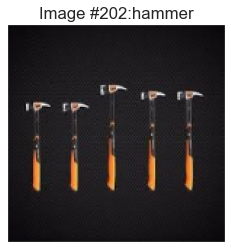

In [10]:
display_random_image(class_names,train_images, train_labels)

In [11]:
def display_examples(class_names, images, labels):
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some example of images of the dataset", fontsize = 16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap = plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

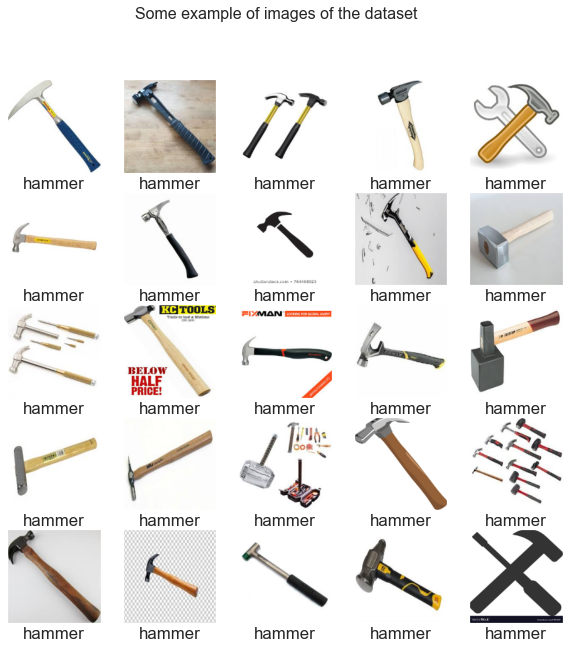

In [12]:
display_examples(class_names, train_images, train_labels)

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

In [14]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['acc'])

In [23]:
history = model.fit(train_images, train_labels, batch_size=128, epochs=20, validation_split = 0.2)

Epoch 1/20
 4/15 [=======>......................] - ETA: 9s - loss: 0.0826 - acc: 0.9707 

KeyboardInterrupt: 

In [16]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['acc'],'bo--', label = "acc")
    plt.plot(history.history['val_acc'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

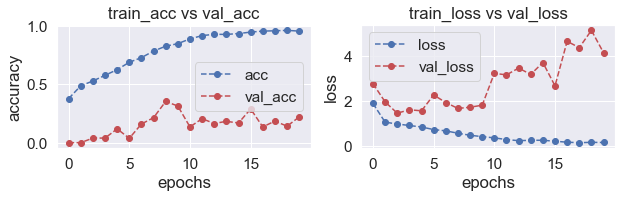

In [17]:
plot_accuracy_loss(history)

In [18]:
test_loss = model.evaluate(test_images, test_labels)

38/38 [==============================] - 2s 43ms/step - loss: 2.1626 - acc: 0.5058


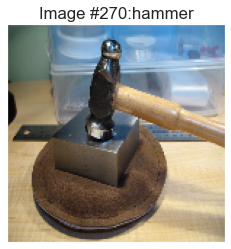

In [19]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

display_random_image(class_names, test_images, pred_labels)

In [20]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    """
        Print 25 examples of mislabeled images by the classifier, e.g when test_labels != pred_labels
    """
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names,  mislabeled_images, mislabeled_labels)

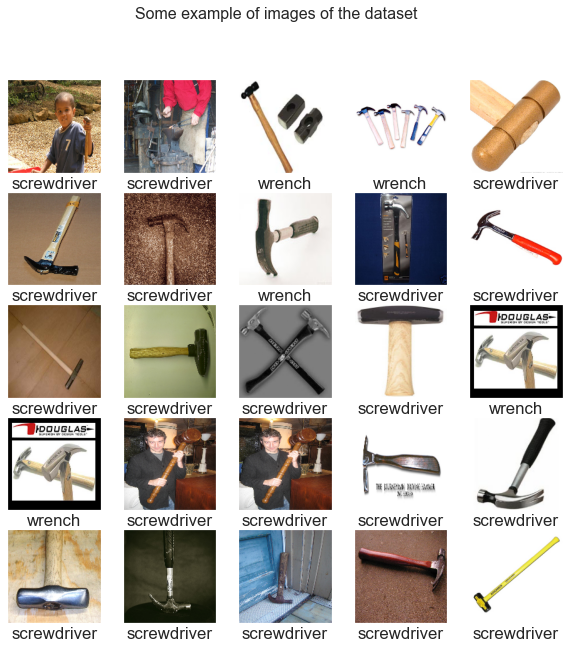

In [21]:
print_mislabeled_images(class_names, test_images, test_labels, pred_labels)

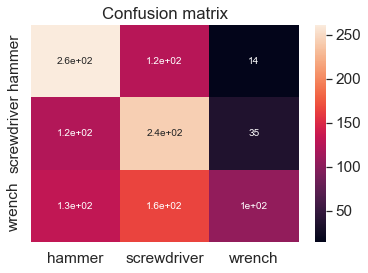

In [22]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()